In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Set plotting style for better visualization
plt.style.use('ggplot')

In [27]:
# --- Load and Prepare NASDAQ Data ---
try:
    nasdaq_df = pd.read_csv('nasdaq_historical.csv')
    print("Successfully loaded nasdaq_historical.csv")
except FileNotFoundError:
    print("Error: 'nasdaq_historical.csv' not found. Please place it in the same directory.")
    nasdaq_df = pd.DataFrame()

if not nasdaq_df.empty:
    nasdaq_df['observation_date'] = pd.to_datetime(nasdaq_df['observation_date'])
    nasdaq_df = nasdaq_df[nasdaq_df['observation_date'] >= '2010-01-01'].copy()
    nasdaq_df['NASDAQCOM'] = pd.to_numeric(nasdaq_df['NASDAQCOM'], errors='coerce')
    nasdaq_df = nasdaq_df.ffill()
    nasdaq_df.set_index('observation_date', inplace=True)
    nasdaq_df['Index_Return'] = nasdaq_df['NASDAQCOM'].pct_change()
    nasdaq_df.dropna(inplace=True)
    print("NASDAQ data prepared.")

# --- Load and Prepare Interest Rate Data ---
try:
    rates_df = pd.read_csv('interest_rates_historical.csv')
    print("Successfully loaded interest_rates_historical.csv")
except FileNotFoundError:
    print("Error: 'interest_rates_historical.csv' not found. Please place it in the same directory.")
    rates_df = pd.DataFrame()

if not rates_df.empty:
    rates_df['observation_date'] = pd.to_datetime(rates_df['observation_date'])
    # Convert FEDFUNDS from percentage to decimal format
    rates_df['FEDFUNDS'] = rates_df['FEDFUNDS'] / 100
    rates_df.set_index('observation_date', inplace=True)
    print("Interest rate data prepared.")

Successfully loaded nasdaq_historical.csv
NASDAQ data prepared.
Successfully loaded interest_rates_historical.csv
Interest rate data prepared.


In [28]:
# --- Merge NASDAQ and Interest Rate Data ---
if not nasdaq_df.empty and not rates_df.empty:
    # Merge the daily stock data with the monthly interest rate data.
    # `merge_asof` matches each daily date to the most recent monthly rate observation.
    df_merged = pd.merge_asof(nasdaq_df, rates_df, left_index=True, right_index=True)
    df_merged.dropna(inplace=True)
    print("Merged NASDAQ and interest rate data successfully.")
    print("Data range after merge:", df_merged.index.min().date(), "to", df_merged.index.max().date())
else:
    df_merged = pd.DataFrame()

Merged NASDAQ and interest rate data successfully.
Data range after merge: 2010-01-05 to 2025-05-29


In [29]:
# --- Dynamic TER Calculation based on Leverage ---
leverage_points = np.array([1, 2, 3])
ter_points = np.array([0.003, 0.006, 0.0075])
coefficients = np.polyfit(leverage_points, ter_points, 2)
ter_function = np.poly1d(coefficients)
a, b, c = coefficients
print("\n--- Dynamic Expense Ratio Model ---")
print(f"Fitted Quadratic Equation: TER = {a:.6f}*L^2 + {b:.6f}*L + {c:.6f}")
print("-----------------------------------")


--- Dynamic Expense Ratio Model ---
Fitted Quadratic Equation: TER = -0.000750*L^2 + 0.005250*L + -0.001500
-----------------------------------


In [30]:
# --- Function to Find Optimal Leverage for a Given SOFR Rate ---
def find_optimal_leverage_for_rate(sofr_rate, df, ter_func, swap_spread, trading_cost_factor):
    """
    Calculates the optimal leverage factor for a given fixed SOFR rate.
    """
    leverage_range = np.arange(1.0, 4.01, 0.1) # Using a step of 0.1 for faster calculation
    results = []

    for l_factor in leverage_range:
        current_er = ter_func(l_factor)
        gross_return = l_factor * df['Index_Return']
        daily_financing_cost = (l_factor - 1) * (sofr_rate + swap_spread) / 365
        daily_er_cost = (1 + current_er)**(1/365) - 1
        daily_trading_cost = df['Index_Return'].abs() * l_factor * trading_cost_factor

        letf_return_series = gross_return - daily_financing_cost - daily_er_cost - daily_trading_cost
        # Use product of (1 + daily_return) for cumulative growth calculation
        final_performance = (1 + letf_return_series).prod()
        results.append((l_factor, final_performance))

    results_df = pd.DataFrame(results, columns=['Leverage', 'Final_Performance'])
    optimal_leverage = results_df.loc[results_df['Final_Performance'].idxmax()]['Leverage']
    return optimal_leverage

In [31]:
# --- Main Calculation: Create Optimal Leverage Hash Map ---
optimal_leverage_map = {}
MAP_FILENAME = 'optimal_leverage_map.npy'

if not df_merged.empty:
    # Check if the map has already been calculated and saved
    if os.path.exists(MAP_FILENAME):
        print(f"\nLoading existing leverage map from '{MAP_FILENAME}'...")
        optimal_leverage_map = np.load(MAP_FILENAME, allow_pickle=True).item()
        print("Leverage map loaded.")
    else:
        print("\nCalculating optimal leverage for each SOFR rate... This will take several minutes.")
        # Define simulation parameters
        SWAP_SPREAD = 0.0040
        TRADING_COST_FACTOR = 0.002847

        # Define the range of SOFR rates to test (0.06% to 19.10%)
        sofr_range = np.arange(0.0006, 0.1911, 0.0001)

        # Use tqdm for a progress bar in the console
        for rate in tqdm(sofr_range, desc="Processing SOFR Rates"):
            rate_key = round(rate, 4)
            optimal_leverage = find_optimal_leverage_for_rate(rate, df_merged, ter_function, SWAP_SPREAD, TRADING_COST_FACTOR)
            optimal_leverage_map[rate_key] = optimal_leverage

        print("Finished creating the optimal leverage map.")
        # Save the map to a file
        try:
            np.save(MAP_FILENAME, optimal_leverage_map)
            print(f"Optimal leverage map saved to '{MAP_FILENAME}'")
        except Exception as e:
            print(f"Could not save map: {e}")


Calculating optimal leverage for each SOFR rate... This will take several minutes.


Processing SOFR Rates: 100%|██████████| 1905/1905 [00:09<00:00, 191.14it/s]

Finished creating the optimal leverage map.
Optimal leverage map saved to 'optimal_leverage_map.npy'


In [32]:
# --- Dynamic Leverage Strategy Simulation ---
if not df_merged.empty and optimal_leverage_map:
    print("\nRunning simulation with dynamic leverage strategy...")

    # 1. Determine the target leverage for each day based on the historical FEDFUNDS rate
    map_keys = np.array(list(optimal_leverage_map.keys()))

    def get_leverage_from_map(rate):
        # Find the key in our calculated map that is closest to the historical rate
        closest_key_index = np.abs(map_keys - rate).argmin()
        closest_key = map_keys[closest_key_index]
        return optimal_leverage_map[closest_key]

    # Map each day's FEDFUNDS rate to its corresponding optimal leverage
    df_merged['Dynamic_Leverage'] = df_merged['FEDFUNDS'].apply(get_leverage_from_map)
    # Smooth the leverage to simulate a more realistic monthly rebalancing
    df_merged['Smoothed_Leverage'] = df_merged['Dynamic_Leverage'].rolling(window=21, min_periods=1).mean()

    # 2. Calculate daily returns for the dynamic strategy
    leverage = df_merged['Smoothed_Leverage']
    current_er = ter_function(leverage)
    borrowing_rate = df_merged['FEDFUNDS']
    SWAP_SPREAD = 0.0040
    TRADING_COST_FACTOR = 0.002847

    gross_return = leverage * df_merged['Index_Return']
    daily_financing_cost = (leverage - 1) * (borrowing_rate + SWAP_SPREAD) / 365
    daily_er_cost = (1 + current_er)**(1/365) - 1
    daily_trading_cost = df_merged['Index_Return'].abs() * leverage * TRADING_COST_FACTOR

    df_merged['Strategy_Return'] = gross_return - daily_financing_cost - daily_er_cost - daily_trading_cost

    # 3. Calculate cumulative performance
    initial_price = df_merged['NASDAQCOM'].iloc[0]
    df_merged['Index_Performance'] = initial_price * (1 + df_merged['Index_Return']).cumprod()
    df_merged['Strategy_Performance'] = initial_price * (1 + df_merged['Strategy_Return']).cumprod()

    print("Dynamic strategy simulation complete.")


Running simulation with dynamic leverage strategy...
Dynamic strategy simulation complete.


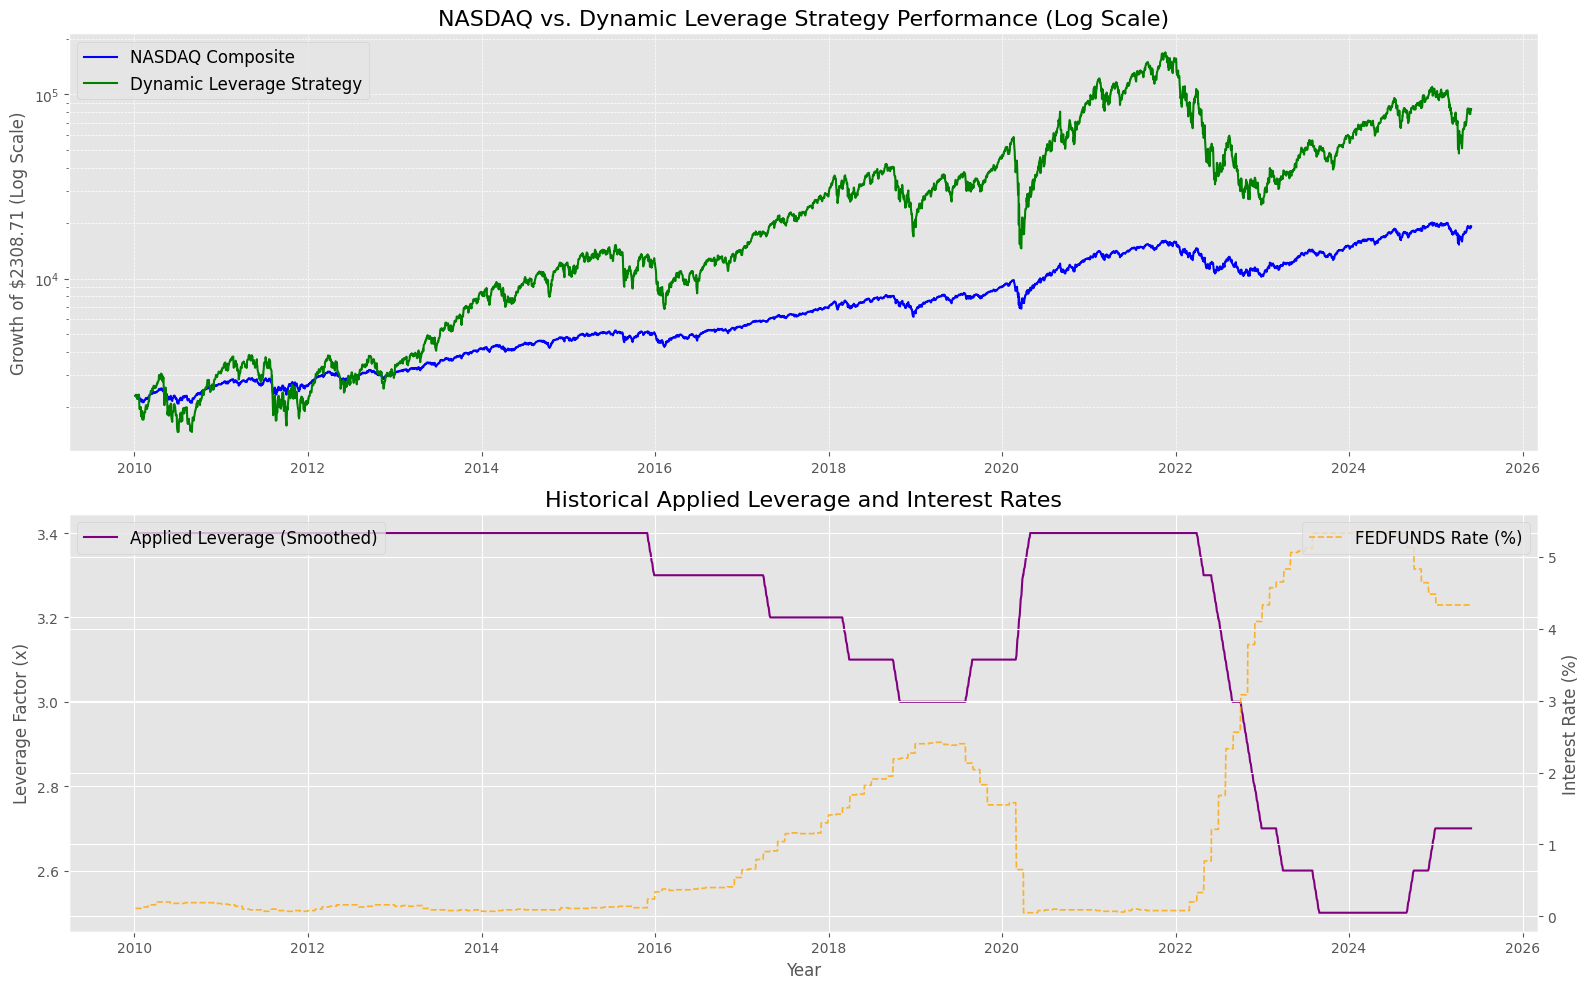


--- Final Performance ---
Initial Investment on 2010-01-05: $2,308.71
End Date: 2025-05-29
NASDAQ Composite Final Value:   $19,178.28
Dynamic Strategy Final Value: $83,093.16
-------------------------


In [33]:
# --- Final Plotting and Results ---
if 'Strategy_Performance' in df_merged.columns:
    plt.figure(figsize=(16, 10))

    # Top Plot: Strategy vs NASDAQ Performance
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(df_merged.index, df_merged['Index_Performance'], label='NASDAQ Composite', color='blue', linewidth=1.5)
    ax1.plot(df_merged.index, df_merged['Strategy_Performance'], label='Dynamic Leverage Strategy', color='green', linewidth=1.5)
    ax1.set_yscale('log')
    ax1.set_title('NASDAQ vs. Dynamic Leverage Strategy Performance (Log Scale)', fontsize=16)
    ax1.set_ylabel(f'Growth of ${initial_price:.2f} (Log Scale)', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Bottom Plot: Historical Leverage and Interest Rates
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(df_merged.index, df_merged['Smoothed_Leverage'], label='Applied Leverage (Smoothed)', color='purple', linewidth=1.5)
    ax2.set_title('Historical Applied Leverage and Interest Rates', fontsize=16)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Leverage Factor (x)', fontsize=12)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True)

    # Create a secondary y-axis for the interest rate on the bottom plot
    ax3 = ax2.twinx()
    ax3.plot(df_merged.index, df_merged['FEDFUNDS'] * 100, label='FEDFUNDS Rate (%)', color='orange', linestyle='--', linewidth=1.2, alpha=0.8)
    ax3.set_ylabel('Interest Rate (%)', fontsize=12)
    ax3.legend(loc='upper right', fontsize=12)

    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    # --- Display Final Results ---
    end_price_index = df_merged['Index_Performance'].iloc[-1]
    end_price_strategy = df_merged['Strategy_Performance'].iloc[-1]

    print("\n--- Final Performance ---")
    print(f"Initial Investment on {df_merged.index[0].date()}: ${initial_price:,.2f}")
    print(f"End Date: {df_merged.index[-1].date()}")
    print(f"NASDAQ Composite Final Value:   ${end_price_index:,.2f}")
    print(f"Dynamic Strategy Final Value: ${end_price_strategy:,.2f}")
    print("-------------------------")
else:
    print("\nSkipping calculations because data was not loaded or strategy simulation failed.")